## Dataset

The Stereo-seq dataset captures a whole adult mouse brain slice. The barcoded spots are arranged in a grid with a distance of 0.5 μm between spots. In total, this dataset profiled 26,177 genes in more than 42,000,000 spots with an average of 3.3 unique molecular identifier (UMI) counts per spot. The brain slice was imaged with nucleic acid staining, allowing for segmentation of the nucleus using image-based methods.

### Download Stereo-seq dataset

To get the data for this competition, you need to download the transcriptomics data [Mouse_brain_Adult_GEM_bin1.tsv.gz](https://ftp.cngb.org/pub/SciRAID/stomics/STDS0000058/Bin1_matrix/Mouse_brain_Adult_GEM_bin1.tsv.gz) and the stain image data [Mouse_brain_Adult.tif](https://ftp.cngb.org/pub/SciRAID/stomics/STDS0000058/Image/Mouse_brain_Adult.tif) from [MOSTA](https://db.cngb.org/stomics/mosta/download/).

The file of detected RNAs should follow the following format in a tab-delimited file:
```
geneID  row  column  counts
```



### Preprocess the stain image
Here some code is given to demonstrate how to do the preprocess of Stereo-seq dataset. This code is highly based on the source code of SCS. You can refer to [environment.yml](https://github.com/chenhcs/SCS/blob/main/environment.yml) to check the package required.

In [32]:
import pandas as pd
from tifffile import TiffFile
import spateo
from matplotlib import pyplot as plt

In [1]:
# Path to TSV file and stain image
# Modify to your own path
st_data_path = "/import/home2/yhchenmath/Dataset/CellSeg/SCS/mouse_brain/Mouse_brain_Adult_GEM_bin1.tsv"
tif_data_path = "/import/home2/yhchenmath/Dataset/CellSeg/SCS/mouse_brain/Mouse_brain_Adult.tif"
# Store the preprocess result
out_dir = "/import/home2/yhchenmath/Dataset/CellSeg/SCS/mouse_brain/preprocess"

In [5]:
# Glance of st and tif
st = pd.read_csv(st_data_path, sep = '\t')
tif = TiffFile(tif_data_path)

In [17]:
print(st.head())
print(st.describe())
print(f"\nShape of the stain image: {tif.pages[0].shape}")

          geneID      x      y  MIDCounts
0  0610005C13Rik  11864  11748          3
1  0610005C13Rik   6632   9074          1
2  0610005C13Rik  10339  15898          2
3  0610005C13Rik   4290  10831          2
4  0610005C13Rik   5714   9053          2
                  x             y     MIDCounts
count  8.076870e+07  8.076870e+07  8.076870e+07
mean   9.005620e+03  1.237652e+04  1.708280e+00
std    2.242615e+03  3.206872e+03  9.823206e-01
min    3.225000e+03  6.175000e+03  1.000000e+00
25%    7.312000e+03  9.821000e+03  1.000000e+00
50%    9.059000e+03  1.223100e+04  1.000000e+00
75%    1.083300e+04  1.492100e+04  2.000000e+00
max    1.372400e+04  2.012400e+04  3.500000e+01

Shape of the stain image: (26455, 26449)


Using python package [spateo](https://spateo-release.readthedocs.io/en/latest/), we can read the stain image and the gene data together in [Annotated data](https://anndata.readthedocs.io/en/latest/) object:

In [19]:
# UMI counting matrix and stain image
adata = spateo.io.read_bgi_agg(st_data_path, tif_data_path)

|-----> Constructing count matrices.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.


In [30]:
# The shape of adata is different from the shape of stain image due to some transformation in package spateo
# adata.shape[0/1] = tif.shape[0/1] - min(st['x']/st['y'])
adata

AnnData object with n_obs × n_vars = 23230 × 20274
    uns: '__type', 'pp', 'spatial'
    layers: 'stain'

Since it is such a large image, we can process it (or segment it later) patch by patch. So we can divide the whole image into several patches.

In [40]:
# You can change the position here
adata.layers['unspliced'] = adata.X
startx = 0
starty = 3600
patch_size = 1200
adatasub = adata[startx:startx+patch_size, starty:starty+patch_size]

There is a slightly unmatch between the spatial transcription and the stain image. So we need to align them.

|-----> <select> stain layer in AnnData Object
|-----> <select> unspliced layer in AnnData Object
|-----> Refining alignment in rigid mode.


Loss -8.0147e-03: 100%|█████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.05it/s]

|-----> Transforming layers ['stain']
|-----> <select> stain layer in AnnData Object
|-----> <insert> stain to layers in AnnData Object.
|-----> <select> unspliced layer in AnnData Object
|-----> <select> stain layer in AnnData Object
|-----> <select> unspliced layer in AnnData Object


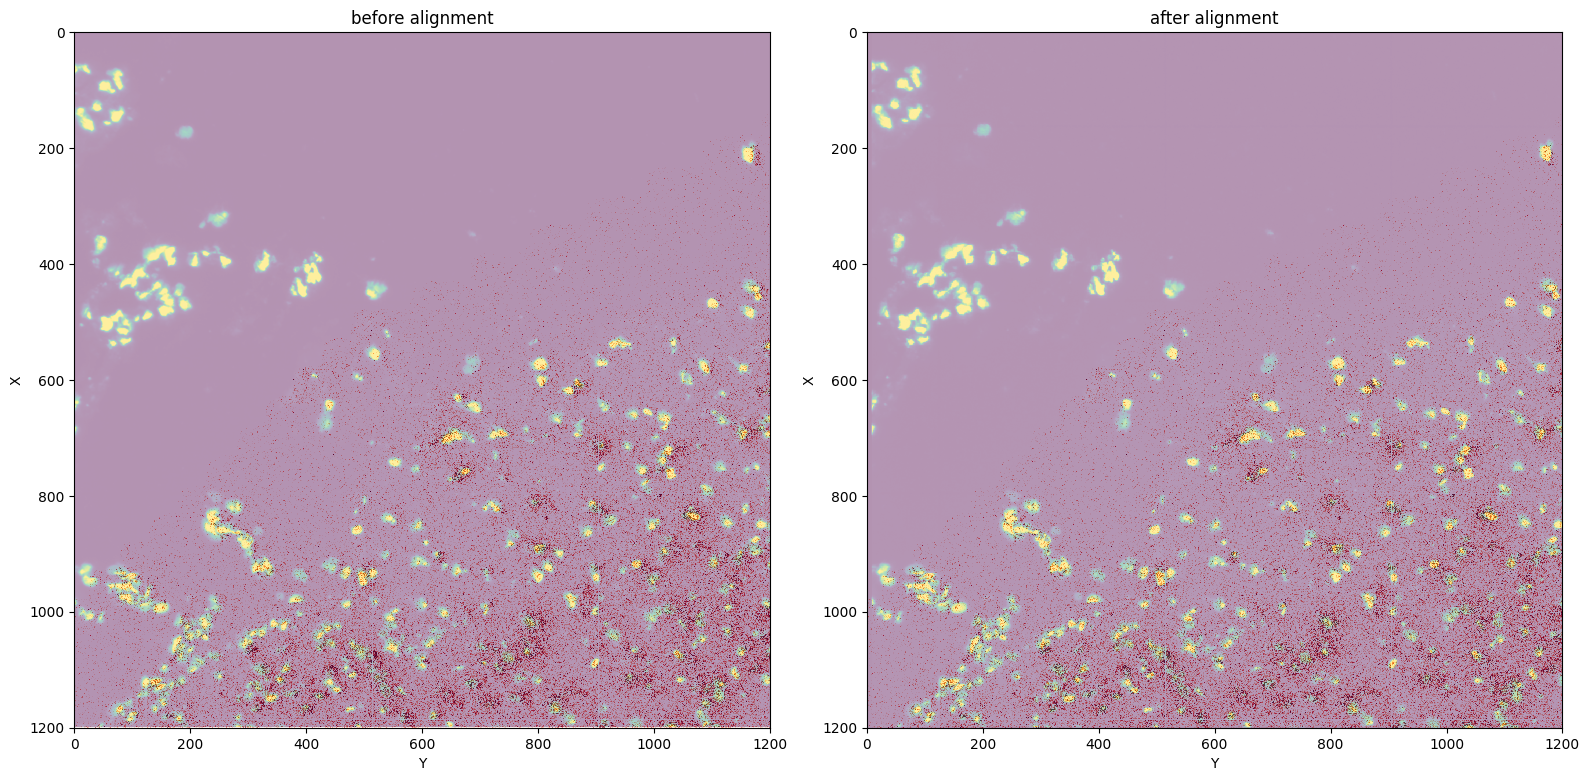

In [42]:
beforesub = adatasub.layers['stain'].copy()
spateo.cs.refine_alignment(adatasub, mode = 'rigid', transform_layers=['stain'])
# Plot
fig, axes = plt.subplots(ncols=2, figsize=(16, 8), tight_layout=True)
axes[0].imshow(beforesub)
spateo.pl.imshow(adatasub, 'unspliced', ax=axes[0], alpha=0.6, cmap='Reds', vmax=10, use_scale=False, save_show_or_return='return')
axes[0].set_title('before alignment')
spateo.pl.imshow(adatasub, 'stain', ax=axes[1], use_scale=False, save_show_or_return='return')
spateo.pl.imshow(adatasub, 'unspliced', ax=axes[1], alpha=0.6, cmap='Reds', vmax=10, use_scale=False, save_show_or_return='return')
axes[1].set_title('after alignment')
plt.show()

We can do nuclei segmentation based on the stain image:

|-----> <select> stain layer in AnnData Object
|-----> Constructing nuclei mask from staining image.
|-----> <insert> stain_mask to layers in AnnData Object.
|-----> <select> stain_mask layer in AnnData Object


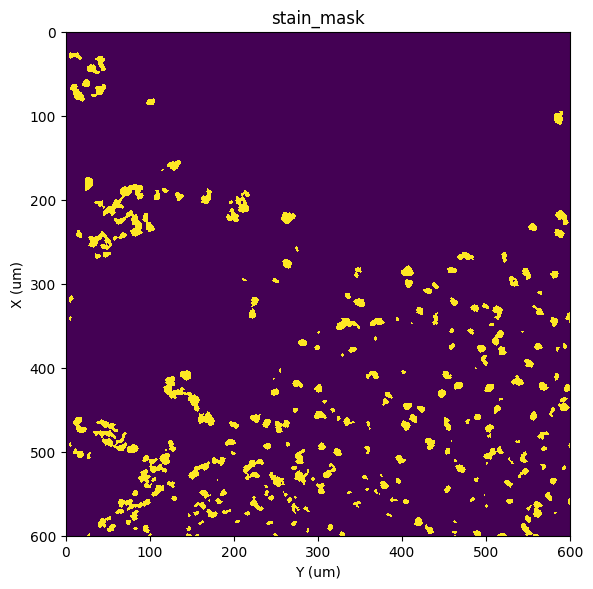

In [43]:
# nucleus segmentation from staining image
# global and local thresholding: Opencv with some morphological operations
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
spateo.cs.mask_nuclei_from_stain(adatasub, otsu_classes=4, otsu_index=1)
spateo.pl.imshow(adatasub, 'stain_mask', ax=ax)

We can also use Watershed algorithm to find the segmentation

|-----> <select> stain_mask layer in AnnData Object
|-----> Finding peaks with minimum distance 7.
|-----> <insert> stain_distances to layers in AnnData Object.
|-----> <insert> stain_markers to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> stain_mask layer in AnnData Object
|-----> <select> stain_markers layer in AnnData Object
|-----> Running Watershed.
|-----> <insert> watershed_labels to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> watershed_labels layer in AnnData Object


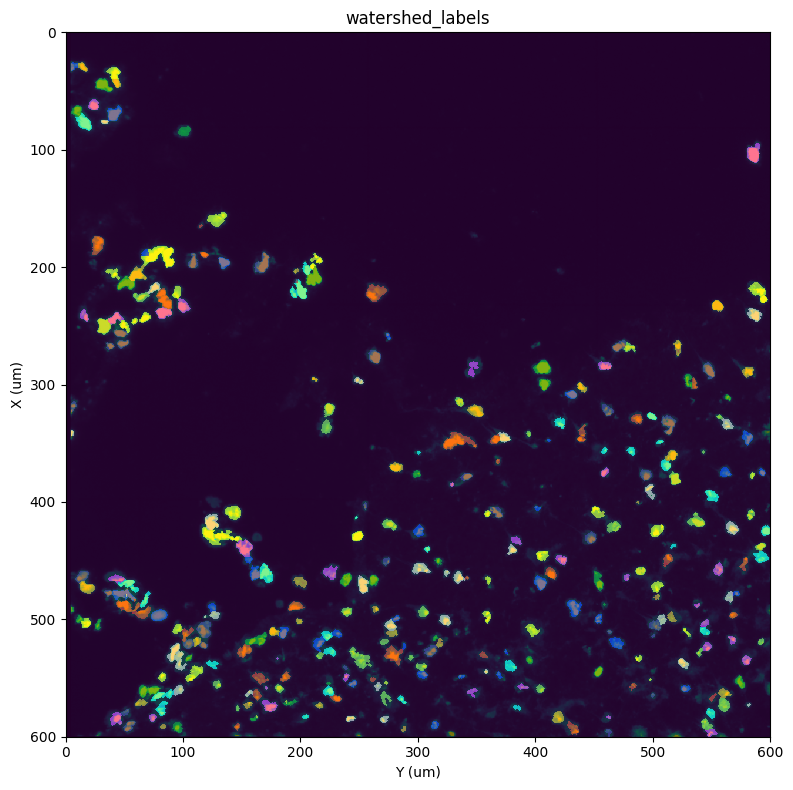

In [45]:
spateo.cs.find_peaks_from_mask(adatasub, 'stain', 7)
spateo.cs.watershed(adatasub, 'stain', 5, out_layer='watershed_labels')
ig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
spateo.pl.imshow(adatasub, 'stain', save_show_or_return='return', ax=ax)
spateo.pl.imshow(adatasub, 'watershed_labels', labels=True, alpha=0.5, ax=ax)

In [62]:
# Save the result
import os
if not os.path.exists('./results'):
    os.makedirs('./results')
adatasub.write(os.path.join('./results',
                             "watershed_labels_" + str(startx) + ':' + str(starty) + ':' + str(patch_size) + ':' + str(patch_size) + '.h5ad'))

In [70]:
import tifffile

adatasub.layers['stain']
tifffile.imwrite('/import/home2/yhchenmath/Code/CellSegCompetition/results/tiff_sub.tif', adatasub.layers['stain'])

In [71]:
image = tifffile.imread('/import/home2/yhchenmath/Code/CellSegCompetition/results/tiff_sub.tif')

In [67]:
image

array([[0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       ...,
       [0, 0, 0, ..., 7, 7, 8],
       [0, 0, 0, ..., 7, 8, 8],
       [0, 0, 0, ..., 8, 8, 8]], dtype=uint8)

In [68]:
adatasub.layers['stain']

array([[0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       ...,
       [0, 0, 0, ..., 7, 7, 8],
       [0, 0, 0, ..., 7, 8, 8],
       [0, 0, 0, ..., 8, 8, 8]], dtype=uint8)

You can check `adatasub.layers['watershed_labels']` to get more details.

### Preprocess Spatial Gene Expression
We show how to process the spatial gene expression in the TSV file.

In [46]:
df_process = st.copy()
# Minus the min value to make the start is 0
df_process['x'] = st['x'] - st['x'].min()
df_process['y'] = st['y'] - st['y'].min()
# Drag out current patch
df_patch =              df_process[(df_process['x'] >= startx) & (df_process['x'] < startx + patch_size) & (df_process['y'] >= starty) & (df_process['y'] < starty + patch_size)]
print(df_patch.head())

            geneID     x     y  MIDCounts
3    0610005C13Rik  1065  4656          2
252  0610009B22Rik  1026  4393          1
276  0610009B22Rik  1117  4755          1
358  0610009B22Rik   981  4680          2
371  0610009B22Rik  1178  4698          1


We use a 2D sparse matrix to store all the data. Its shape is: `(Patch_size * Patch_size)xGeneNum`

In [54]:
from natsort import natsort
import multiprocessing as mp
import numpy as np
import os
from scipy.sparse import lil_matrix, vstack
import scipy
import anndata as ad
import scanpy as sc
def process_gene_chunk(id ,gene_chunk, df, map_height, map_width):
    map_fe = lil_matrix((map_height * map_width, len(gene_chunk)), dtype=np.int8)
    for i_fe, fe in enumerate(gene_chunk):
        df_fe = df.loc[df['geneID'] == fe]
        for idx in df_fe.index:
            idx_x = df.loc[idx]['x'] - startx
            idx_y = df.loc[idx]['y'] - starty
            # Store in sparse matrix
            map_fe[idx_x * map_width + idx_y, i_fe] += df.loc[idx]['MIDCounts']
    # Save in a temp file
    scipy.sparse.save_npz(f'./temp/temp_{id}.npz', map_fe.tocsr())

In [52]:
gene_names = df_patch['geneID'].unique()
gene_names = natsort.natsorted(gene_names)
# multi-process
if not os.path.exists('./temp/'):
    os.makedirs('./temp/')
n_processes = mp.cpu_count()
gene_names_chunks = np.array_split(gene_names, n_processes)
processes = []
for i, gene_chunk in enumerate(gene_names_chunks):
    p = mp.Process(target=process_gene_chunk, args=(i, gene_chunk, df_patch,
                                                patch_size, patch_size))
    processes.append(p)
    p.start()
for p in processes:
    p.join()

# Combine all the temp files
patch_gene_map = None
for i in range(n_processes):
    temp = scipy.sparse.load_npz(f'./temp/temp_{i}.npz').T
    if patch_gene_map is None:
        patch_gene_map = temp
    else:
        patch_gene_map = vstack([patch_gene_map, temp])
patch_gene_map = patch_gene_map.T

In [53]:
# Check sparse matrix
# If you want to index (x,y) in the raw patch position, then use patch_gene_map[idx_x * patch_size + idx_y]
patch_gene_map

<1440000x15546 sparse matrix of type '<class 'numpy.int8'>'
	with 453046 stored elements in Compressed Sparse Row format>

Next, since we have lots of genes, we can get the most 2000 highly variable genes:

In [55]:
# Create anndata
all_exp_merged_bins_ad = ad.AnnData(
    patch_gene_map,
    obs=pd.DataFrame(index=[i for i in range(patch_gene_map.shape[0])]),
    var=pd.DataFrame(index=[name for name in gene_names]),
)
sc.pp.highly_variable_genes(all_exp_merged_bins_ad, n_top_genes=2000, flavor='seurat_v3', span=1.0)

/home/yhchenmath/anaconda3/envs/cellseg/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



In [58]:
selected_genes = all_exp_merged_bins_ad.var[all_exp_merged_bins_ad.var.highly_variable].index
hv_df_index = [g in selected_genes for g in df_patch['geneID']]
df_patch_hv_plot = df_patch.loc[hv_df_index][['x', 'y']].to_numpy()  - np.array([startx, starty])

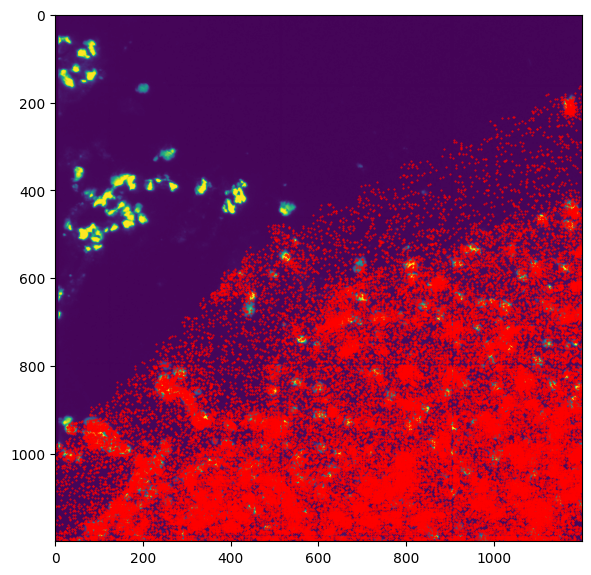

In [61]:
# Plot the gene points scatter and the corresponding stain
# Each red point represent a gene expressed at that spot
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
ax.imshow(adatasub.layers['stain'])
ax.scatter(df_patch_hv_plot[:, 1], df_patch_hv_plot[:, 0], s=0.2, c='r')
plt.show()